In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
sys.path.append('../../src/')
# import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

In [3]:
# Stationary Block Bootstrap 2.7.2 of Lahiri
def SB(X, p, N):
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # N: number of SB samples
     
    I = np.random.choice(len(X), N, replace=True)
    L = np.random.geometric(p=p, size=N)
    L[L<=20] = 20
    
    X_repeat = np.repeat(X, np.floor(np.max(L)/len(X))+1, axis=0)
    samples = []
    for i in range(len(I)):
        s = X_repeat[I[i]: I[i]+L[i]]
        samples.append(s)
    
    return samples

In [10]:
ES5 = lambda x: ES(0.05, x)
ES1 = lambda x: ES(0.01, x)
VaR5 = lambda x: VaR(0.05, x)
VaR1 = lambda x: ES(0.01, x)
ERM = lambda x: ERM_estimate_trapezoidal(10, x)

risk_measure_arr = [Variance, ES5, ES1, VaR5, VaR1, ERM, Variance]
rm_dict = dict(zip(risk_measures, risk_measure_arr))
risk_measure_name = ['Variance', 'ES 95%', 'ES 99%', 'VaR 95%', 'VaR 99%', 'ERM', 'Variance']
rm2name =  dict(zip(risk_measures, risk_measure_name))
new_coin_names = coin_names = ['BTC', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ADA', 'ETH', 'LTC', 'XRP']

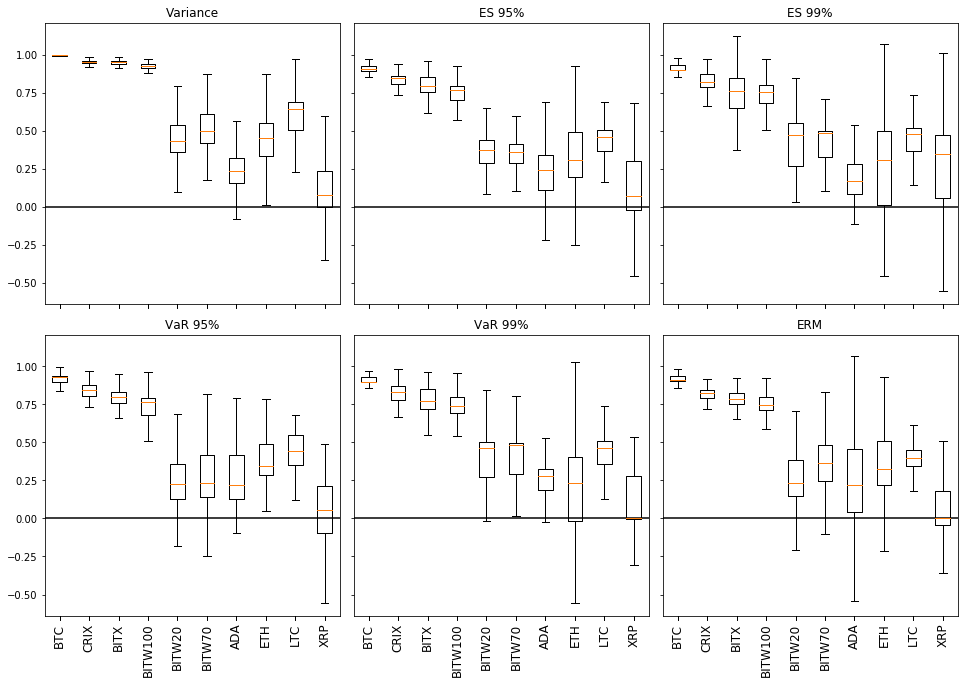

In [11]:
start = '2019-10-21'
factor = 4.5
xsize = 3*factor
ysize = 2*factor

SB_p = 1/250
SB_N = 1000

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

HE_outer2 = []
length_outer2 = []
for p, rm in enumerate(risk_measures[:-1]):
    HE_outer = []
    length_outer = []
    
    risk_fn = rm_dict[rm]
    
    for q, rn in enumerate(order):
        if rm != 'CH':
            path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
            %(rn, rm)
        else:
            path = '../../results/%s/MM/rh_cross_hedge.csv'\
            %(rn)    
            
        _df = pd.read_csv(path)

        _df = _df.loc[_df.Date >= start,:] 
        
        samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

        HE = []
        length = []
        for s in samples:
            risk_rh = risk_fn(s[:,0])
            risk_rs = risk_fn(s[:,1])
            HE.append(1-risk_rh/risk_rs)
            length.append(len(s))

        HE_outer.append(HE)
        length_outer.append(length)
    HE_outer2.append(HE_outer)
    length_outer2.append(length_outer)

    if p<=2:
        axs[0, p].boxplot(HE_outer, showfliers=False)
        axs[0, p].set_title(rm2name[rm])
        axs[0, p].axhline(y=0, xmin=0, xmax=1, color='black')

    else:
        axs[1, p-3].boxplot(HE_outer, showfliers=False)
        axs[1, p-3].set_title(rm2name[rm], fontsize=12)
        axs[1, p-3].axhline(y=0, xmin=0, xmax=1, color='black')

plt.tight_layout()

for p, a in enumerate(axs):
    xtickNames = plt.setp(axs[p], xticklabels=new_coin_names)
    plt.setp(xtickNames, rotation=90, fontsize=12)